Watershed

56561.5


C:\Users\julie\AppData\Local\Temp\ipykernel_17852\1979062364.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=50, labels=thresh)


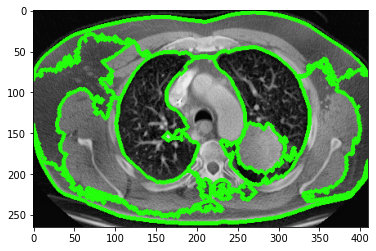

In [27]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt

# Load in image, convert to gray scale, and Otsu's threshold
image = cv2.imread('Cancer_enh.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=50, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)

print(total_area)
plt.imshow(image)
plt.show()

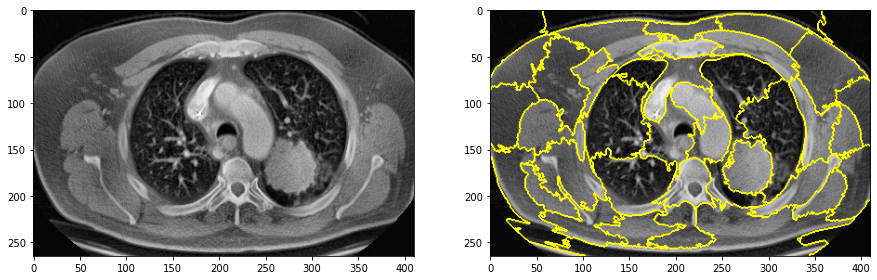

In [53]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
 
# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
img=cv2.imread("Cancer_enh.png",0)/255
 
# Applying SLIC segmentation
# for the edges to be drawn over
img_segments = slic(img, n_segments=50,compactness=0.1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(img, cmap='gray')
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(img, img_segments))

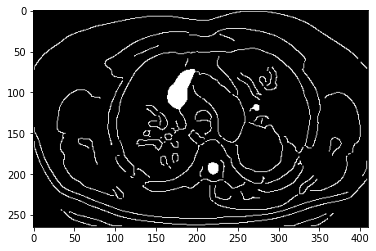

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 ,os
from math import ceil
import pickle
import time
from skimage import io, feature
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage import morphology
from skimage.feature import canny
from skimage.restoration import estimate_sigma

foreground_value = 0
foreground_pixels=[]
segmented_images=[]


def read_image_files(dir):
    images = []
    filenames = os.listdir(dir)
    for filename in filenames:
        images.append(cv2.imread(dir + filename, 0))
    return images



def edge_based_segmentation(image):
    noise = estimate_sigma(image)
    edges = canny(image, sigma=3)
    filled = ndi.binary_fill_holes(edges)
    filled_cleaned = morphology.remove_small_objects(filled, 2)
    segmented_images.append(filled_cleaned)
    pixels=np.argwhere(filled_cleaned == foreground_value)
    foreground_pixels.append(pixels)
    return

img=cv2.imread('Cancer_enh.png',0)/255
edge_based_segmentation(img)

np.save('EdgeBasedSegmentation',foreground_pixels)
plt.imshow(segmented_images[0],'gray')

Text(0.5, 1.0, 'Otsu')

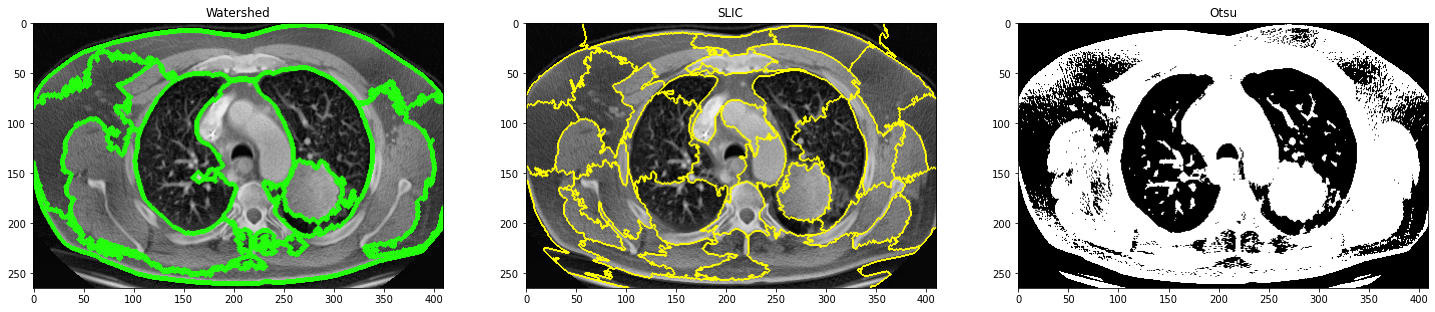

In [36]:
import matplotlib.pyplot as plt
import cv2

fig = plt.figure()
fig.set_figheight(11)
fig.set_figwidth(25)

fig.add_subplot(1,3,1)
plt.imshow(image, cmap='gray')
plt.title('Watershed')

fig.add_subplot(1,3,2)
plt.imshow(mark_boundaries(img, img_segments))
plt.title('SLIC')

img=cv2.imread('Cancer_enh.png',0)
ret, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
fig.add_subplot(1,3,3)
plt.imshow(thresh, cmap='gray')
plt.title('Otsu')

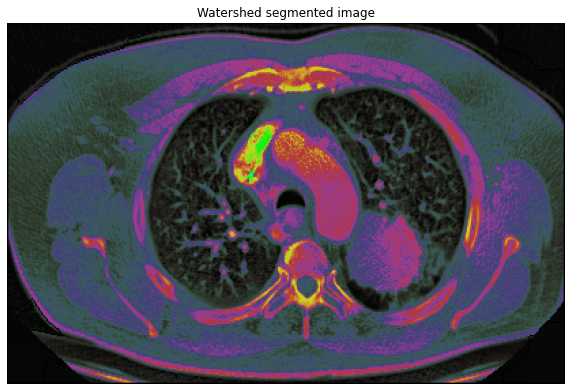

In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed as skwater

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(rgb_img)
  elif ctype=='hsv':
    rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    plt.imshow(rgb)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

img = cv2.imread('Cancer_enh.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 12)
    
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
   
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
     
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

     
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
ShowImage('Watershed segmented image',im1,'gray')

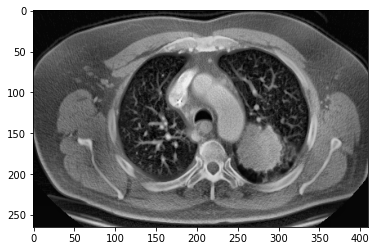

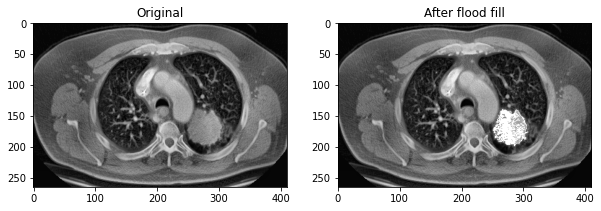

In [37]:
import cv2
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
import sys

img=cv2.imread('Cancer_enh.png',0)
plt.imshow(img,cmap='gray')

light_coat = flood_fill(img, seed_point=(175, 275), new_value=255, tolerance=20)
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('on')

ax[1].imshow(light_coat, cmap='gray')
#ax[1].plot(275, 175, 'ro')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('on')

plt.show()